In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import stopro.data_generator.sinusoidal as sinusoidal
from stopro.data_generator.sin_1D_naive import Sin1DNaive
from stopro.data_generator.sin_1D import Sin1D
from stopro.data_preparer.data_preparer import DataPreparer
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
import stopro.GP.gp_naive as gp_1D_naive
from stopro.data_handler.data_handle_module import HdfOperator
from stopro.GP.kernels import define_kernel
from stopro.solver.optimizers import optimize_by_adam
import stopro.GP.gp_1D_laplacian as gp_1D_laplasian

In [3]:
## import modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.functions.pivoted_cholesky as pc
import bbmm.functions.pivoted_cholesky_numpy as pcn
import bbmm.utils.calc_logdet as calc_logdet
import bbmm.utils.calc_trace as calc_trace

# import bbmm.operators.dense_linear_operator as dense_linear_operator
# import bbmm.operators.root_linear_operator as root_linear_operator
# import bbmm.operators.diag_linear_operator as diag_linear_operator
# import bbmm.operators._linear_operator as _linear_operator
# import bbmm.operators.psd_sum_linear_operator as psd_sum_linear_operator
# import bbmm.operators.root_linear_operator as root_linear_operator
# from bbmm.functions.pivoted_cholesky_numpy import pivoted_cholesky_numpy
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
    importlib.reload(pcn)
    # importlib.reload(dense_linear_operator)
    # importlib.reload(root_linear_operator)
    # importlib.reload(diag_linear_operator)
    # importlib.reload(_linear_operator)
    # importlib.reload(psd_sum_linear_operator)
    # importlib.reload(root_linear_operator)
    importlib.reload(sinusoidal)
reload()

In [4]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [5]:
def rel_error(true, pred):
    true_max = np.max(true)
    zero_threshold = (
        true_max * 1e-7
    )  # ignore the data that test value is smaller than 1e-7
    index = np.where(abs(true) > zero_threshold)
    if np.all(abs(true) <= zero_threshold):
        rel_error = 0.0
        return rel_error
    true2 = true[index]
    pred2 = pred[index]
    rel_error = np.abs((true2 - pred2) / true2)
    # print(rel_error)
    return rel_error

In [6]:
project_name = 'data'
simulation_name = 'test_sinusoidal'

In [8]:
data_preparer = DataPreparer(
    project_name, simulation_name, class_data_generator=sinusoidal.Sinusoidal)
data_preparer.load_params(
    system_name="sinusoidal", use_existing_params=False
)
# data_preparer.params_generate_training[''] = 1000

data_preparer.create_directory()

data_preparer.make_data()
data_preparer.save_params_prepare()
data_preparer.save_params_main()
data_preparer.save_lbls()

In [9]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [10]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
scale = 100
r_train_scaled = [_r * scale for _r in r_train]
r_test_scaled = [_r * scale for _r in r_test]
# delta_y_train_scaled = delta_y_train.copy()
# delta_y_train_scaled[4] = delta_y_train_scaled[4] / scale**2
delta_y_train_scaled = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train_scaled = jnp.append(
        delta_y_train_scaled, f_train[i] / scale - μ_train[i]
    )

args_predict = r_test_scaled, μ_test, r_train_scaled, delta_y_train_scaled, params_model["epsilon"]

In [11]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_sinusoidal_independent.GPSinusoidalWithoutPIndependent(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
)
gp_model.set_constants(*args_predict)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

## check K^{-1}y with precondition

In [12]:
scale = 0.
length = 3.
noise = 1e-06
init = jnp.array([scale, length, length, scale, length, length, scale, length, length])

In [13]:
_K = gp_model.trainingK_all(init, r_train_scaled)
K = gp_model.add_eps_to_sigma(_K, noise, noise_parameter=None)

In [14]:
is_positive_definite(K), jnp.linalg.cond(K)

(True, Array(5639698.40724896, dtype=float64))

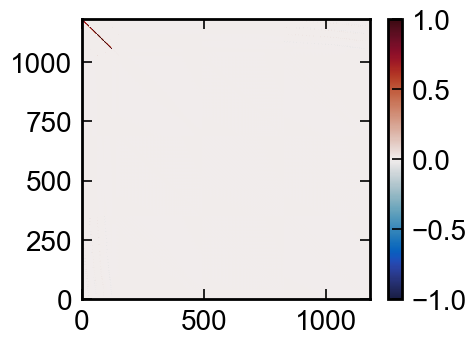

In [28]:
fig, ax = plt.subplots(figsize=(5, 4))
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [16]:
devices = jax.devices()
print("Available devices:", devices)

# GPUがあればその情報を表示
gpu_devices = [device for device in devices if device.device_kind == 'gpu']
if gpu_devices:
    for i, gpu_device in enumerate(gpu_devices):
        print(f"GPU {i + 1}: {gpu_device}")
else:
    print("No GPU devices found.")

Available devices: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]
No GPU devices found.


In [19]:
rank=80
noise=1e-06
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(_K, rank=rank, noise=noise, min_preconditioning_size=1)

In [20]:
is_positive_definite(precondition(K)), jnp.linalg.cond(precondition(K))

(True, Array(146999.21495814, dtype=float64))

In [21]:
precondition(K)

Array([[ 1.00000000e+00, -1.11022302e-10,  9.60898128e+01, ...,
        -1.10928939e+00, -1.13033972e+00,  8.00488895e-16],
       [-1.11022302e-10,  9.99999999e-01, -5.28812370e+02, ...,
         2.50015825e+00,  2.65735560e+00,  6.56524277e-13],
       [ 1.11022302e-10, -4.44089210e-10,  6.94367397e+02, ...,
         1.79992261e+00,  1.97334268e+00,  3.48985073e-13],
       ...,
       [ 1.09154731e-11,  4.83969304e-12,  6.64019656e+00, ...,
         1.98225086e+02,  1.94826100e+02,  0.00000000e+00],
       [ 8.24228580e-12,  7.48408620e-12,  1.18458934e+01, ...,
         1.43166456e+02,  1.60040033e+02,  1.73472348e-12],
       [ 4.14328007e-12,  9.02509034e-12,  1.59052574e+01, ...,
        -1.61250024e+02, -1.60964184e+02,  1.00000000e+00]],      dtype=float64)

In [22]:
def setup_loss_mpcg(rank=15, n_tridiag=10, seed=0, tolerance=0.01, max_tridiag_iter=20, min_preconditioning_size=2000):
    def loss_mpcg(init, *args):

        r, delta_y, noise = args

        K = gp_model.trainingK_all(init, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size)
        if precondition:
            zs = precond_lt.zero_mean_mvn_samples(n_tridiag, seed=0)
        else:
            zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y), n_tridiag))
        # zs_norms = jnp.linalg.norm(zs, axis=0, keepdims=True)
        # zs = zs/zs_norms
        rhs = jnp.concatenate([zs, delta_y.reshape(-1, 1)], axis=1)

        Kinvy, j,t_mat = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=n_tridiag, 
            max_tridiag_iter=max_tridiag_iter
        )

        logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)

        yKy = jnp.dot(delta_y, Kinvy[:, -1])
        loss = (yKy + logdet)/2 + len(delta_y)/2*jnp.log(jnp.pi*2)    
        # print(yKy)
        # print(logdet)
        return loss
    return loss_mpcg

In [23]:
loglikelihood_mpcg = setup_loss_mpcg(rank=80, n_tridiag=20, max_tridiag_iter=40, tolerance=1, min_preconditioning_size=1)

In [24]:
func_mpcg = logposterior(loglikelihood_mpcg, params_optimization)
dfunc_mpcg = jit(grad(func_mpcg, 0))
hess_mpcg= hessian(func_mpcg)

In [25]:
params_optimization["lr"] = 1e-02
params_optimization["print_process"] = True

In [26]:
params_optimization["maxiter_scipy"] = [0]
params_optimization["maxiter_GD"] = 5

In [27]:
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: 9.821335481312728
step   0 loss: 9.8213 max_grad: 39.44479, arg=7
norm_of_grads: 39.97266
[ 0.01  2.99  3.01 -0.01  3.01  3.01  0.01  2.99  3.01]
step   1 loss: 9.3069 max_grad: 39.64071, arg=7
norm_of_grads: 40.15689
[ 0.02  2.98  3.02 -0.02  3.02  3.02  0.02  2.98  3.02]
step   2 loss: 8.7922 max_grad: 39.78319, arg=7
norm_of_grads: 40.28758
[ 0.0299  2.9701  3.03   -0.03    3.03    3.03    0.03    2.97    3.03  ]
step   3 loss: 8.2781 max_grad: 39.86662, arg=7
norm_of_grads: 40.35908
[ 0.0396  2.9601  3.0401 -0.04    3.04    3.04    0.04    2.96    3.04  ]
step   4 loss: 7.7653 max_grad: 39.88782, arg=7
norm_of_grads: 40.36823
[ 0.0493  2.9503  3.0502 -0.0499  3.05    3.0499  0.05    2.95    3.05  ]


In [28]:
opts = [{"x": init}]
# np.arrayのinstanceを生成している文章があると，jax.gradを使うことができない
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
)

loss before optimize: 0.5865197366681477


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray([[1.000001   0.89807857 0.65292993 ... 0.         0.         0.        ]
 [0.89807857 1.000001   0.89972558 ... 0.         0.         0.        ]
 [0.65292993 0.89972558 1.000001   ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.01543335 0.01459375 0.01234158]
 [0.         0.         0.         ... 0.01459375 0.01543335 0.01459375]
 [0.         0.         0.         ... 0.01234158 0.01459375 0.01543335]], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array([[1.000001  , 0.89807857, 0.65292993, ..., 0.        , 0.        ,
        0.        ],
       [0.89807857, 1.000001  , 0.89972558, ..., 0.        , 0.        ,
        0.        ],
       [0.65292993, 0.89972558, 1.000001  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01543335, 0.01459375,
        0.01234158],
       [0.        , 0.        , 0.        , ..., 0.01459375, 0.01543335,
        0.01459375],
       [0.        , 0.        , 0.        , ..., 0.01234158, 0.01459375,
        0.01543335]], dtype=float64)
  tangent = Traced<ShapedArray(float64[1180,1180])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[1180,1180]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f96184a1580>, in_tracers=(Traced<ShapedArray(float64[1180,1180]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x7f96101ed7b0; to 'JaxprTracer' at 0x7f96101ef510>], out_avals=[ShapedArray(float64[1180,1180])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f64[1180,1180]. let  in (a,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f95a4217c70>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

## check if we can reach convergenparams_optimization

In [54]:
params_optimization["eps"] = 0.001
params_optimization

{'eps': 0.001,
 'index_fixed': None,
 'interval_check': None,
 'loss_ridge_regression': False,
 'lr': 0.01,
 'maxiter_GD': 5,
 'maxiter_scipy': [0],
 'method_GD': 'adam',
 'method_scipy': ['Nelder-Mead'],
 'print_process': False}

In [48]:
params_optimization["maxiter_GD"] = 900
params_optimization["print_process"] = False

In [49]:
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: 9.821335481312728


In [50]:
len(norm_of_grads_list)

900

In [51]:
len(loss)

901

In [57]:
params_optimization["maxiter_GD"] = 900
params_optimization["print_process"] = False
opts = [{"x": init}]
opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimize_by_adam(
    func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
)

loss before optimize: 0.5863597474254184


Exception: gradient of loss became nan

In [ ]:
len(loss_mpcg)

In [ ]:
# params_optimization["maxiter_GD"] = 73
# params_optimization["print_process"] = False
# opts = [{"x": init}]
# opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimize_by_adam(
#     func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
# )
## diverged

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}
kwargs_mpcg = {"alpha": 0.7}

axs[0][0].plot(loss, **kwargs, label='default')
axs[0][0].plot(loss_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0], **kwargs_mpcg)
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1], **kwargs_mpcg)
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

In [ ]:
def setup_predictor_mpcg(rank=15, n_tridiag=10, seed=0, tolerance=0.001, max_tridiag_iter=20, max_iter_cg=1000, min_preconditioning_size=2000):
    def predictor_mpcg(opt, *args):

        r_test, μ_test, r, delta_y, noise = args

        K = gp_model.trainingK_all(opt, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
        
        Kab = gp_model.mixedK_all(opt, r_test, r_train)
        Kaa = gp_model.testK_all(opt, r_test)

        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size)
        rhs = jnp.concatenate([delta_y.reshape(-1, 1)], axis=1)

        Kinvy, j = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=0, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )
        
        rhs = Kab.T

        Kinvk, j = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=0, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )


        kKy = jnp.squeeze(jnp.matmul(Kab, Kinvy), axis=1)
        kKk = jnp.matmul(Kab, Kinvk)
        print(kKy.shape)
        sec0 = 0
        sec1 = 0
        fs_mpcg = []
        Sigmas_mpcg = []
        for i in range(len(r_test)):
            sec1 += len(r_test[i])
            fs_mpcg.append(μ_test[0] + kKy[sec0:sec1])
            Sigmas_mpcg.append(Kaa[sec0:sec1, sec0:sec1] - kKk[sec0:sec1, sec0:sec1])
            sec0 += len(r_test[i])
        # f_infer_mpcg = [μ_test[0] + jnp.squeeze(kKy, axis=1)]
        # Sigma_mpcg = Kaa - kKk
        # print(yKy)
        # print(logdet)
        return fs_mpcg, Sigmas_mpcg
    return predictor_mpcg

In [ ]:
predictor_mpcg = setup_predictor_mpcg(rank=80, min_preconditioning_size=1)
f_infer_mpcg, Sigma_mpcg = predictor_mpcg(opt_mpcg, *args_predict)
# std_mpcg = jnp.sqrt(jnp.diag(Sigma_mpcg))

In [ ]:
fs, Σs = predictor(opt, *args_predict)

In [ ]:
maximum_height = 1 / 2 + 0.2

In [ ]:
y_num = params_generate_test["test_num"]
x_num = len(r_test[0][::y_num])
y_grid = np.linspace(-maximum_height, maximum_height, y_num)
x_grid = np.linspace(0, 2.5, x_num)

In [ ]:
sinusoidal = Sinusoidal(0.2, 2.5, 1.)

In [ ]:
vlimit = params_plot['val_limits']

In [ ]:
params_plot

In [ ]:
cmaps = [cmo.cm.dense, cmo.cm.balance, cmo.cm.dense]
# 値のプロット
vname = 'ux'
fig, axs = plt.subplots(nrows=2)

dot_size = 25
index = vnames["test"].index(vname)
ax_index = 0
axs[ax_index].set_title(vname)
f_for_plot = sinusoidal.change_outside_values_to_zero(
    r_test[index], np.array(f_infer_mpcg[index]),
)
f_mesh = f_for_plot.reshape(y_num, x_num)
mappable = axs[ax_index].pcolormesh(
    x_grid,
    y_grid,
    f_mesh,
    cmap=cmaps[index],
    vmin=vlimit[0][0],
    vmax=vlimit[0][1],
    shading="nearest",
)
# mappable = axs[ax_index].scatter(r_test[index][:, 0], r_test[index][:, 1], c=f[index], marker='o',
#                                  s=dot_size, cmap=cmaps[index], vmin=vlimit[0], vmax=vlimit[1])
divider = make_axes_locatable(axs[ax_index])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mappable, cax=cax)
axs[ax_index].set_aspect("equal", adjustable="box")


vname='uy'

index = vnames["test"].index(vname)
ax_index = 1
axs[ax_index].set_title(vname)
f_for_plot = sinusoidal.change_outside_values_to_zero(
    r_test[index], np.array(f_infer_mpcg[index]),
)
f_mesh = f_for_plot.reshape(y_num, x_num)
mappable = axs[ax_index].pcolormesh(
    x_grid,
    y_grid,
    f_mesh,
    cmap=cmaps[index],
    vmin=vlimit[1][0],
    vmax=vlimit[1][1],
    shading="nearest",
)
# mappable = axs[ax_index].scatter(r_test[index][:, 0], r_test[index][:, 1], c=f[index], marker='o',
#                                  s=dot_size, cmap=cmaps[index], vmin=vlimit[0], vmax=vlimit[1])
divider = make_axes_locatable(axs[ax_index])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mappable, cax=cax)
axs[ax_index].set_aspect("equal", adjustable="box")

In [77]:
sample = sinusoidal.Sinusoidal(0.2, 2.5, 1.0)

In [82]:
i = 0
index_check = sample.get_index_in_channel(r_test[0])
# f_check = fs[i][]

AttributeError: 'Sinusoidal' object has no attribute 'get_index_in_channel'

In [75]:
np.mean(np.abs(fs[0][index_check]-f_test[0][index_check])), np.mean(np.abs(f_infer_mpcg[0][index_check]-f_test[0][index_check]))

IndexError: boolean index did not match shape of indexed array in index 0: got (576, 2), expected (576,)

In [64]:
np.exp(opt), np.exp(opt_mpcg)

(array([2.07145351, 2.44960342]), array([1.14683018, 2.19386859]))